In [3]:
import numpy as np
# config parameters
deepmd_jax_path  = '../'               # Path to deepmd_jax package; change if you run this script at a different directory
precision        = 'default'           # 'default'(fp32), 'low'(mixed 32-16), 'high'(fp64)
# model_path       = 'trained_models/dpsr_chunyidplr.pkl'  # path to the trained model for simulation
model_path       = 'trained_models/new_dp_water_512.pkl'  # path to the trained model for simulation
save_path        = './'                # path to save trajectory
save_prefix      = 'water'             # prefix for saved trajectory
use_model_devi   = False               # compute model deviation of different models
model_devi_paths = ['trained_models/dp_water_2.pkl', 'trained_models/dp_water_3.pkl']
use_dplr         = False                # Use DPLR
wannier_model    = 'trained_models/dw_chunyidplr_1.pkl'  # path to Wannier model in DPLR
memory_cap       = None                # Reduce memory use, sacrificing speed; only for compressed models; if not None, set it to e.g. 1e9, at large as possible so far as no OOM occurs
# simulation parameters; all units in (Angstrom, eV, fs)
dt               = 0.48                # time step (fs)
temp             = 350 * 8.61733e-5    # temperature (Kelvin * unit_convert)
mass             = np.array([15.9994, 1.00784]) * 1.036427e2 # mass by type (AMU * unit_convert)
fix_type         = 'NVT'               # 'NVE' or 'NVT' (uses Nose-Hoover thermostat)
chain_length     = 1                   # NH chain length in NVT
tau              = 2000 * dt           # NH relaxation time in NVT
total_steps      = 10000             # Total number of simulation steps
print_every      = 100                 # Frequency of printing and calculating model deviation
save_every       = 1                   # Frequency of recording trajectory
rcut_buffer      = 1.                  # buffer radius (Angstrom) of neighborlist (can be a list for different types)
# DPLR parameters
beta             = 0.4                 # inverse spread of the point charge distribution
resolution       = 0.2                 # particle mesh grid length = resolution / beta
q_atoms          = [6, 1]              # charge of atomic cores, here Oxygen and Hydrogen
q_wc             = [-8]                # charge of wannier center/centroid

# Prepare initial config in numpy array by whatever way you like
# Required: coord, box, type_list
#    - coord, (N,3): initial config; N stands for number of atoms
#    - box, (3,3): periodic box vectors; make sure it is a diagonal matrix if box is orthorhombic
#    - type_list, (N,): atom type index; start counting from 0; use the same index map as model training
# Optional: velocity, force
#    - velocity, (N,3): initial velocity; if not provided, will be initialized by temperature
#    - force, (N,3): ground truth force of initial config; if provided, will be used in initial model check
# Here as an example we use a configuration from the training dataset
path = '/pscratch/sd/r/ruiqig/polaron_cp2k/aimd/aimd-water/water_128/'
# path = 'data/chunyi_dplr/data/energy_force_data/data/data21/'
# coord = np.load(path + 'set.000/coord.npy')[0].reshape(-1, 3)
# force = np.load(path + 'set.000/force.npy')[0].reshape(-1, 3)
# box = np.load(path + 'set.000/box.npy')[0].reshape(3, 3)
coord = np.load(path + 'set.001/coord.npy')[0].reshape(-1, 3)
force = np.load(path + 'set.001/force.npy')[0].reshape(-1, 3)
box = np.load(path + 'set.001/box.npy')[0].reshape(3, 3)
type_list = np.genfromtxt(path + 'type.raw')
# Example 3: Repeating a prepared config to a larger system
copy = [3,3,3] # number of copies in each direction x,y,z
for k in range(3):
    coord = np.concatenate([(coord + i*box[k])[:,None] for i in range(copy[k])], axis=1).reshape(-1,3)
box = np.diag(copy) @ box
type_list = np.repeat(type_list, np.prod(copy), axis=0)
force = np.repeat(force, np.prod(copy), axis=0)
# end preparing initial config

# from here on, no need to change unless you know what you're doing
%env XLA_PYTHON_CLIENT_PREALLOCATE=false
import jax.numpy as jnp
from jax import jit, random, grad
import flax.linen as nn
import jax, sys, os, warnings
from time import time
from jax_md import space, quantity, simulate
sys.path.append(os.path.abspath(deepmd_jax_path))
from deepmd_jax import data, utils, simulation_utils
from deepmd_jax.dpmodel import DPModel
print('# Starting program on %d device(s):' % jax.device_count(), jax.devices())
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
np.set_printoptions(precision=4, suppress=True)
if precision == 'default':
    jax.config.update('jax_default_matmul_precision', 'float32')
if precision == 'high':
    jax.config.update('jax_enable_x64', True)
if low_memory_mode:
    utils.LOW_MEM_MODE = True
# prepare configuation and model
type_list = type_list.astype(int)
def sort_type(x):             # atoms are sorted by type in simulation
    return x[type_list.argsort(kind='stable')]
@jit
def vmap_inv_sort_type(x):    # sort back to original order
    return x[:,type_list.argsort(kind='stable').argsort(kind='stable')]
type_count = np.bincount(type_list)
coord, force = sort_type(coord), None if not 'force' in vars() else sort_type(force)
mass = jnp.repeat(mass, type_count)              # expand mass vector
model, variables = utils.load_model(model_path)  # load model
model_list, variables_list = [model], [variables]
if use_model_devi:
    for path in model_devi_paths:
        m, v = utils.load_model(path)
        model_list.append(m), variables_list.append(v)
if use_dplr:
    wmodel, wvariables = utils.load_model(wannier_model)
rcut_max = max([m.params['rcut'] for m in model_list] + ([wmodel.params['rcut']] if use_dplr else []))
lattice_args = data.compute_lattice_candidate(box[None], rcut_max)
static_args = nn.FrozenDict({'type_count':type_count, 'lattice':lattice_args})
coord = jax.device_put(coord*jnp.ones(1), jax.sharding.PositionalSharding(jax.devices()).replicate())
displace, shift = space.periodic(jnp.diag(box) if lattice_args['ortho'] else box)
# prepare neighborlist
if not lattice_args['ortho']:
    print('# Neighborlist disabled: Non-orthorhombic box.')
elif rcut_max + np.array(rcut_buffer).max() > np.diag(box).min() / 2:
    print('# Neighborlist disabled: rcut + rcutbuffer larger than half of the box length.')
else:
    use_neighborlist = True
    buffer_size = 1.2
    update_every = max([i for i in [1,2,3,4,5,10] if print_every % i == 0])
    rcut_buffer = np.full(len(type_count), rcut_buffer) if np.array(rcut_buffer).size == 1 else np.array(rcut_buffer)
    rbuffer_array = jnp.repeat(rcut_buffer, type_count)
    neighborlist = simulation_utils.NeighborListLoader(np.diag(box), type_count, rcut_max+rcut_buffer, buffer_size)
    nbrs_list = neighborlist.allocate(coord % jnp.diag(box))
if not use_neighborlist and jax.device_count() > 1:
    print('# Warning: Multiple devices detected but program only runs on 1 device when neighborlist is disabled.')
# prepare energy function
def get_energy_fn(model, variables):
    if use_dplr:
        p3mlr_fn = utils.get_p3mlr_fn(np.diag(box), beta, resolution=resolution)
        qatoms = jnp.array(np.repeat(q_atoms, type_count))
        qwc = jnp.array(np.repeat(q_wc, [type_count[i] for i in wmodel.params['nsel']]))
    def energy_fn(coord, nbrs_list):
        E = model.apply(variables, coord, box, static_args, nbrs_list)[0]
        if not use_dplr:
            return E
        else:
            wc = wmodel.wc_predict(wvariables, coord, box, static_args, nbrs_list)
            return E + p3mlr_fn(jnp.concatenate([coord, wc]), jnp.concatenate([qatoms, qwc]))
    return jit(energy_fn)
energy_fn = get_energy_fn(model, variables) # for simulation
energy_fns = [get_energy_fn(model, variables) for model, variables in zip(model_list, variables_list)] # for model deviation
print('# Model check: NAtoms = ', len(coord), 'Energy = ', energy_fn(coord,nbrs_list), + '' if not 'force' in vars() else
        'Force error = ', ((force + jit(grad(energy_fn))(coord, nbrs_list))**2).mean()**0.5)

env: XLA_PYTHON_CLIENT_PREALLOCATE=false
# Starting program on 1 device(s): [cuda(id=0)]
# Model loaded from 'trained_models/new_dp_water_512.pkl'.
# Lattice vectors for neighbor images: Max 1 out of 1 condidates.


# Neighborlist allocated with size [64, 126]
# Model check: NAtoms =  10368 Energy =  -1616588.1 Force error =  0.03781206


In [4]:
# Initialize simulation state
TIC = time()
if fix_type == 'NVT':
    init_fn, apply_fn = simulate.nvt_nose_hoover(energy_fn, shift, dt, temp, chain_length=chain_length, tau=tau) 
    state = init_fn(random.PRNGKey(0), coord, mass=mass, nbrs_list=nbrs_list)
elif fix_type == 'NVE':                    
    init_fn, apply_fn = simulate.nve(energy_fn, shift, dt)                               
    state = init_fn(random.PRNGKey(0), coord, mass=mass, kT=temp, nbrs_list=nbrs_list)
if 'velocity' in vars():
    state = state.set(momentum = state.mass * velocity)
states_sharding = jax.tree_util.tree_map(lambda x: x.sharding, [state, nbrs_list])
# Define step function
def inner_step_fn(states, i): # inner_step_fn = 1 md step
    state, nbrs_list = states
    state = apply_fn(state, nbrs_list=nbrs_list)
    return (state, nbrs_list), (state.position, state.velocity)
def get_step_fn():  # 1 step_fn = print_every steps        
    def multi_inner_step_fn(states, i): # multi_inner_step_fn = update_every steps + 1 step update neighborlist
        state, nbrs_list = states
        nbrs_list = neighborlist.update(state.position % jnp.diag(box), nbrs_list)
        (state_new, _), (pos, vel) = jax.lax.scan(inner_step_fn, (state,nbrs_list), None, update_every)
        rcut_overflow = (jnp.linalg.norm((state.position-pos-jnp.diag(box)/2)%jnp.diag(box)-jnp.diag(box)/2, axis=-1) > rbuffer_array/2).any()
        return (state_new, nbrs_list), (pos, vel, rcut_overflow)
    def step_fn(state, nbrs_list=None): 
        if not use_neighborlist:
            return jax.lax.scan(inner_step_fn, (state,None), None, print_every, unroll=1)
        else:
            return jax.lax.scan(multi_inner_step_fn, (state, nbrs_list), None, print_every//update_every, unroll=1)
    return jit(step_fn)
step_fn = get_step_fn()
# jit functions for calculating quantities
@jit
def get_quantity(state, nbrs_list):
    PE = energy_fn(state.position, nbrs_list=nbrs_list)
    T = quantity.temperature(velocity=state.velocity, mass=state.mass) / 1.380649e-23 * 1.602176634e-19
    KE = quantity.kinetic_energy(velocity=state.velocity, mass=state.mass)
    if fix_type == 'NVT':
        inv = simulate.nvt_nose_hoover_invariant(energy_fn, state, temp, nbrs_list=nbrs_list)
    elif fix_type == 'NVE':
        inv = PE + KE
    return T, KE, PE, inv
@jit
def compute_model_devi(coord, nbrs_list):
    all_forces = jnp.array([-grad(energy_fn)(coord, nbrs_list) for energy_fn in energy_fns])
    return jnp.std(all_forces, axis=0).max()

# Run simulation
print('# Step\tTemp\tKE\tPE\tInvariant\tModel Dev\ttime')
print('####################################################################')
pos_traj, vel_traj, model_devi_traj = [], [], []
i, tic, NBRS_FLAG, save_idx = 0, time(), False, 0
while i < total_steps:
    T, KE, PE, inv = get_quantity(state, nbrs_list)
    model_devi = compute_model_devi(state.position, nbrs_list) if use_model_devi else 0.
    print('{}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.3f}\t{:.2f}'.format(
            i, T, KE, PE, inv, model_devi, (time() - tic)))
    tic = time()
    if not use_neighborlist:
        (state, _), (pos, vel) = step_fn(state)
    else:
        state, nbrs_list = jax.device_put([state, nbrs_list], states_sharding)
        (state_new, nbrs_list_new), (pos, vel, rcut_overflow) = step_fn(state, nbrs_list)
        if any([nbrs.did_buffer_overflow for nbrs in nbrs_list_new]):
            if NBRS_FLAG:
                NBRS_FLAG, buffer_size = False, buffer_size + 0.05
                print('# Neighbor list overflow for a second time; Increasing buffer_size to', buffer_size)
                neighborlist = simulation_utils.NeighborListLoader(jnp.diag(box),type_count,rcut_max+rcut_buffer,buffer_size)
                nbrs_list = neighborlist.allocate(coord % jnp.diag(box))
            else:
                NBRS_FLAG = True
            nbrs_list = neighborlist.allocate(state.position % jnp.diag(box))
            states_sharding = jax.tree_util.tree_map(lambda x: x.sharding, [state, nbrs_list])
            continue
        NBRS_FLAG = False
        if rcut_overflow.any():
            if update_every == 1:
                print('# Error: rcut_buffer overflow for a single step; Check for bugs or increase rcut_buffer')
                break
            else:
                update_every = (update_every + 1) // 2
                step_fn = get_step_fn()
                print('# rcut_buffer overflow; Decreasing update_every to', update_every)
                continue
        state, nbrs_list = state_new, nbrs_list_new
        pos, vel = pos.reshape(-1,pos.shape[2],3), vel.reshape(-1,vel.shape[2],3)
    i += print_every
    pos_traj.append(np.array(vmap_inv_sort_type(pos[save_every-1::save_every]), dtype=np.float32))
    vel_traj.append(np.array(vmap_inv_sort_type(vel[save_every-1::save_every]), dtype=np.float32))
    model_devi_traj.append(model_devi)
    if i >= total_steps or len(pos_traj)*pos_traj[0].nbytes > 8e9: # max file size ~ 8GB (adjust if needed)
        np.save(save_path + '/' + save_prefix + '_pos_%d.npy' % save_idx, np.concatenate(pos_traj))
        np.save(save_path + '/' + save_prefix + '_vel_%d.npy' % save_idx, np.concatenate(vel_traj))
        pos_traj, vel_traj, model_devi_traj = [], [], []
        save_idx += 1
print('# Trajectory saved to \'%s_*\'.' % os.path.realpath(save_path+'/'+save_prefix))
Time = time() - TIC
print('# Finished simulation in %dh %dm %ds.' % (Time//3600,(Time%3600)//60,Time%60))

# Step	Temp	KE	PE	Invariant	Model Dev	time
####################################################################
0	348.47	467.00	-1616588.12	-1616121.12	0.000	1.08
100	342.85	459.48	-1616580.62	-1616121.12	0.000	4.91
200	346.74	464.69	-1616585.75	-1616121.00	0.000	0.60
300	353.09	473.20	-1616594.38	-1616121.25	0.000	0.61
400	355.03	475.80	-1616596.88	-1616121.25	0.000	0.61
500	352.69	472.66	-1616593.75	-1616121.25	0.000	0.61
600	350.80	470.13	-1616591.38	-1616121.25	0.000	0.61


KeyboardInterrupt: 

In [ ]:
np.save('traj_nvt_350new.npy', np.array(traj, dtype=np.float32))

In [ ]:
%env XLA_PYTHON_CLIENT_PREALLOCATE=false
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
traj1 = jnp.load('traj_nve.npy')[10000:]
traj2 = jnp.load('traj_nvt_300new.npy')[10000:]
traj3 = jnp.load('traj_nvt_350new.npy')[10000:]
traj4 = jnp.load('/pscratch/sd/r/ruiqig/old/h2o_dp_example/rerun/traj.npy')[10000:]
traj1 = traj1[:len(traj4)]
traj2 = traj2[:len(traj4)]
# traj3 = traj3[:len(traj4)]

env: XLA_PYTHON_CLIENT_PREALLOCATE=false


0.2021033
0.21448293
0.21082759


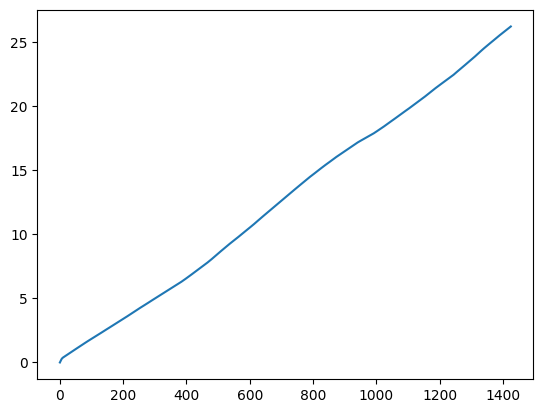

In [ ]:
msd = []
traj = traj3
for i in range(0, 3*len(traj)//4, 100):
    msd.append(((traj[i+1000:len(traj)//4+i, :] - traj[1000:len(traj)//4, :])**2).mean())
plt.plot(msd)
j = 40000
print((((traj[j::10] - traj[:-j:10])**2).sum(axis=-1).mean(axis=0).mean()
       -((traj[j+2100::10] - traj[:-j-2100:10])**2).sum(axis=-1).mean(axis=0).mean()) / -6)
print((msd[650] - msd[550]) / 4.8 / 2)
print((msd[600] - msd[500]) / 4.8 / 2)

In [ ]:
import numpy as np
import ase.io
water_traj = ase.io.read('/pscratch/sd/r/ruiqig/old/h2o_dp_example/rerun/water2.dump', ':')

In [ ]:
water_traj = np.array([i.positions for i in water_traj])

In [ ]:
traj = np.array([i.positions for i in water_traj])
cell = np.array([np.diag(i.cell) for i in water_traj])
for i in range(1, len(traj)):
    traj[i] = traj[i-1] + (traj[i] - traj[i-1] - cell[i]/2) % cell[i] - cell[i]/2

-0.2126019132649913


IndexError: list index out of range

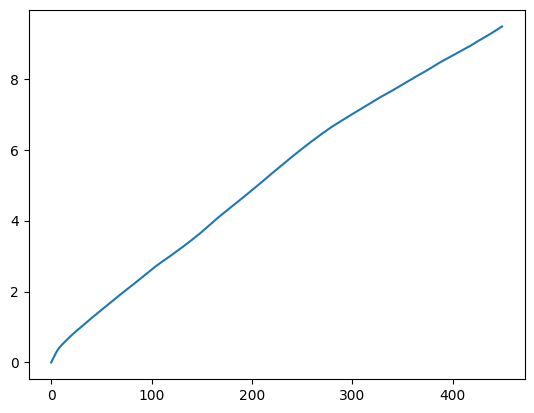

In [ ]:
import matplotlib.pyplot as plt
msd = []
for i in range(0, 3*len(traj)//4, 100):
    msd.append(((traj[i+1000:len(water_traj)//4+i, :] - traj[1000:len(water_traj)//4, :])**2).mean())
plt.plot(msd)
i = 10000
j = 40000
print((((traj[i+j::10] - traj[i:-j:10])**2).sum(axis=-1).mean(axis=0).mean()
       -((traj[i+j+2100::10] - traj[i:-j-2100:10])**2).sum(axis=-1).mean(axis=0).mean()) / 6)
print((msd[1400] - msd[1300]) / 4.8 / 2)
print((msd[1300] - msd[1200]) / 4.8 / 2)

In [ ]:
print((msd[300] - msd[200]) / 4.8 / 2)
print((msd[400] - msd[300]) / 4.8 / 2)

0.22384505891304557
0.1721535352116325
